# Sequence Prediction



In this notebook, Modules of the following Architecture is implemented and compiled. As Seen,  Data is extracted from ```city_search.json```.  
Operations like data format conversion, data extraction, data transfer, and data analysis will be done in the Data Analysis module to find the answer for Q1. An html analysis report file also will be produced by this module
Data Preprocessing module prepares Data for Machine learning. Data for training, evaluating, and testing the machine learning model will be prepared in this module via pre-processing the flat data frame. The training pipeline is responsible for training the deep learning model which will be used in the inference pipeline. The inference pipeline takes a sequence of cities and predicts the next city/cities search in the sequence. Question 4 is the output of the Evaluation report generated by the training module and Q2 will be tackled in the Inference pipeline.

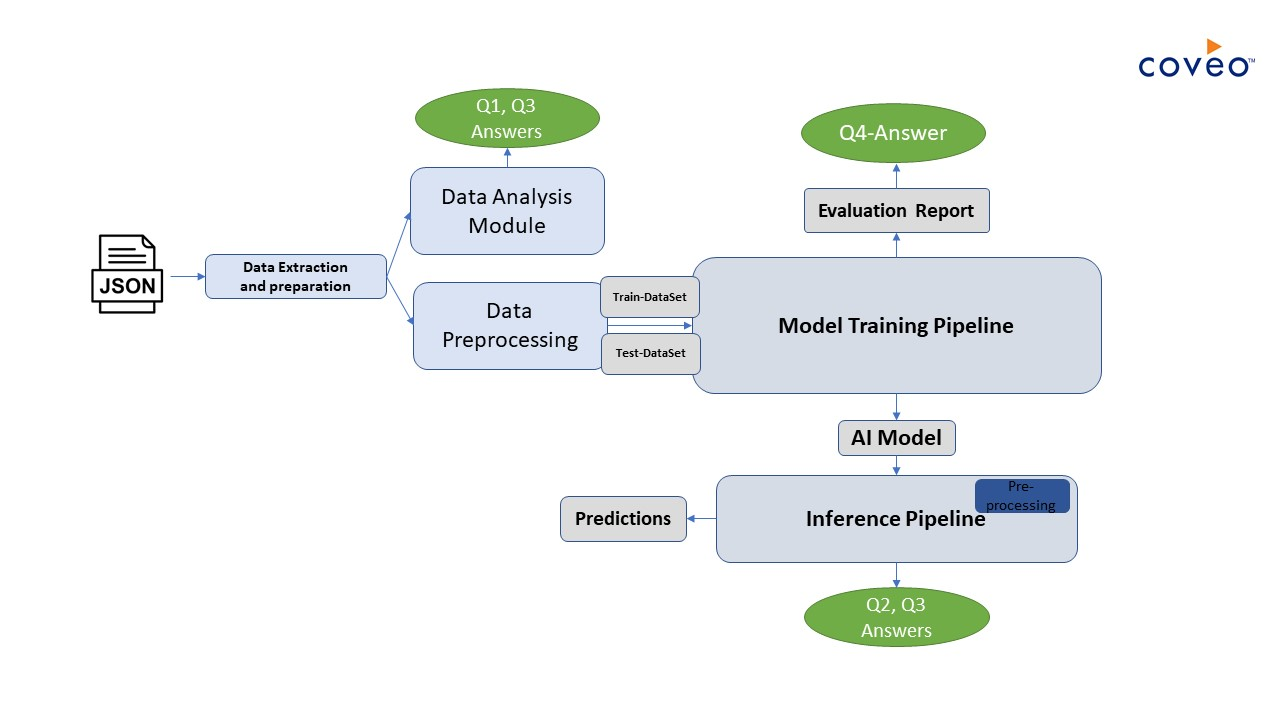

In [1]:
from IPython.display import Image
Image(filename='architecture.jpg')

# Importing all the required Libraries

In [43]:
import pandas as pd
import numpy as np
#import io
import itertools
import os
from pandas_profiling import ProfileReport

import keras  # Deep Learning RNN

import pickle # Saving and loading the objects
import matplotlib.pyplot as plt # Visualization purposes

from matplotlib import pyplot # Visualization purposes

from sklearn.preprocessing import LabelEncoder # Preprocessing
from sklearn.preprocessing import OneHotEncoder # Preprocessing
from sklearn.model_selection import train_test_split # Preprocessing
from keras.layers import LSTM, Dense, Dropout # LSTM Implementation
from keras.models import Sequential # LSTM Implementation
from keras.preprocessing.sequence import pad_sequences; # Padding the input
from keras.models import load_model # For laoding the keras model



# Activate the Logging

In [3]:
import logging # For logging purposes
logging.basicConfig(filename='Logs/app.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s')
# Activating the logging
logging.info('All the libraries have been successfully imported')

# Data Extraction (Reading) and Transformation 

In [4]:
df= pd.read_json('Data/city_search.json') # Rading the Json File

try:        
    df.shape
    df.info()
    df.columns.values
    logging.info('All the libraries have been successfully imported')
except:
    logging.error('Dataframe has not been loaded correctly')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   session_id      20022 non-null  object
 1   unix_timestamp  20022 non-null  object
 2   cities          20022 non-null  object
 3   user            20022 non-null  object
dtypes: object(4)
memory usage: 625.8+ KB


There are only 20022 non-null rows.  
To ease the processing and analysis, one should flatten the nested pandas dataframe 

In [5]:
# Convert the nested Data frame to a Flat one 
df['user'] = df['user'].apply(lambda x: x[0][0])
df_flat = pd.concat([df.drop('user', axis=1), pd.DataFrame(df["user"].to_list(), columns=list(df['user'][0].keys()))], axis=1)
df_flat
#df_flat.to_csv('city_search_flat.csv', index=False)

,session_id,unix_timestamp,cities,user_id,joining_date,country
0,[X061RFWB06K9V],[1442503708],"[New York NY, Newark NJ]",2024,2015-03-22,UK
1,[5AZ2X2A9BHH5U],[1441353991],"[New York NY, Jersey City NJ, Philadelphia PA]",2853,2015-03-28,DE
2,[SHTB4IYAX4PX6],[1440843490],[San Antonio TX],10958,2015-03-06,UK
3,[JBRB8MZGTX3M4],[1427268063],[Edmonton AB],7693,2015-03-12,IT
4,[YJCMPURC2FL9C],[1430559067],"[Phoenix AZ, Houston TX]",7506,2015-02-28,UK
...,...,...,...,...,...,...
20017,[17WJGZOEFEI4W],[1430545204],"[Chicago IL, Montreal QC]",4360,2015-03-21,
20018,[9HCZDQMGU5Z2G],[1434444360],[Chicago IL],2057,2015-03-22,IT
20019,[73ZWORX75Y9A0],[1438584470],[Chicago IL],1203,2015-02-28,IT
20020,[DMWGV9HY74G9T],[1435235491],"[Calgary AB, New York NY]",3699,2015-03-24,ES


A fuctionalized code for data extration is available here:

Now all the global variables will be loaded and be set from a json file. 

In [91]:
def load_config():
    with open('config.json') as data_file:  
        config = json.load(config_file)
        for k in config.keys():
            if k in globals():
                globals()[k] = config[k]


In [6]:
def df_extract(src_location):
    df= pd.read_json(src_location) # Rading the Json File    
    df['user'] = df['user'].apply(lambda x: x[0][0])
    df_flat = pd.concat([df.drop('user', axis=1), pd.DataFrame(df["user"].to_list(), columns=list(df['user'][0].keys()))], axis=1)
    profile = ProfileReport(df_flat, title="Data Analysis Report", explorative=True)
    profile.to_file("Analysis_report.html")
    return(df_flat)


df_flat = df_extract('Data/city_search.json')

# Answer to Question 1

1. There was a bug in the code and for one specific country, the records don't have the country field logged. It just shows up as an empty field (""). The search sessions with a missing country either come from a country that is completely missing from the data, or from one of the countries that are logged in the data. Can you determine which country it is the most likely to be? Explain your hypothesis and the data analysis tasks you did to  find the missing country.


Answer:  Focus on the analysis of Unix timestamp is the best way to find the the unknown country according to its timezone.  Indeed, the timestamp reflects the local time client connect to the traveling agent site is highly correlated with the longitude of the countries.
Thus, I developed the following algorithm to extract the times (which hour in the day) that people from different countries connect to the online travel agency website.   

Text(0.5, 0, 'Countries ')

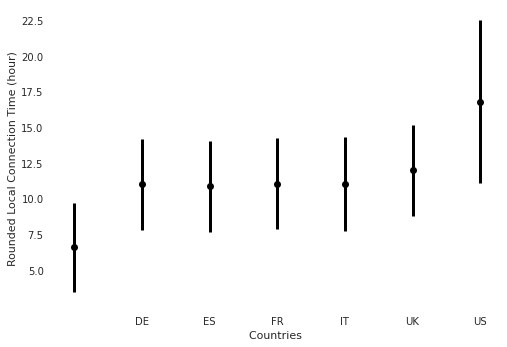

In [7]:
CT_dh = 3600*24 # number of seconds per day
CT_h = 3600 # Number of seconds per hour

# Extract hours that clients connect to the site
df_flat['hour'] = df_flat['unix_timestamp'].apply(lambda x: (int(x[0])%(CT_dh))//CT_h)

# Calculating the statistical characteristics of the Data collected for each country
means = list(df_flat.groupby('country')['hour'].mean())
std = list(df_flat.groupby('country')['hour'].std())
maxes = list(df_flat.groupby('country')['hour'].max())
mins = list(df_flat.groupby('country')['hour'].min())
indexes=list(df_flat.groupby('country')['hour'].mean().index)

#print(means)
# create stacked errorbars:
plt.errorbar(indexes, means, std, fmt='ok', lw=3)
plt.ylabel("Rounded Local Connection Time (hour) ");
plt.xlabel("Countries ")

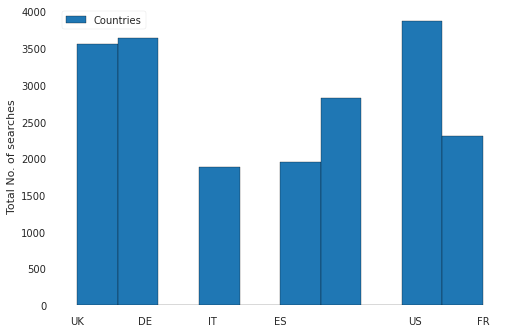

In [8]:
# Plotting the histogram for the number of searches per country.

plt.hist(df_flat['country'].values,  label="Countries", histtype='bar', ec='black')
plt.legend()
plt.ylabel("Total No. of searches");

As seen above, The time difference between countries is revealed above. European countries have almost the same longitude and consequently the same average while the USA has around 5 hours lag compared to European countries and since it is much wider than these countries the ```std value``` is greater for this country. From the figure above, we can conclude that the unknown country is on the east side of the European countries with (4-5) hours difference. 

The second figure, shows the number of searches for countries. As shown above, the number of searches from this country is more than Estonia and Italy and less than UK, Denmark, and France. Thus, the country has a noticeable population that can afford traveling and due to the small STD value, the unknown country is not wide (covering vast longitudes) like  Russia or China.

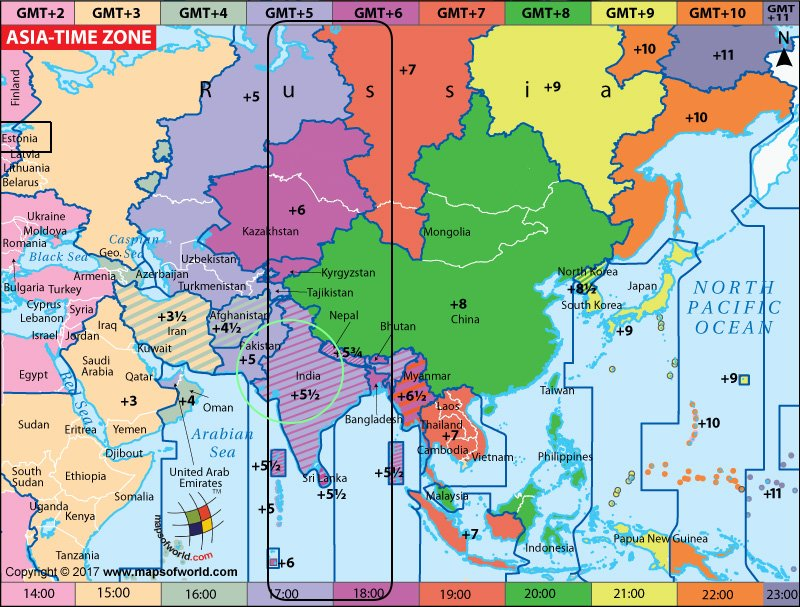

In [9]:
Image(filename='Asia-Time-Zone-Map.jpg')

As shown above,  our search get limited to either India or Pakistan. 

Finally, at the end of this module, an analysis over the data is povided via profiling.

In [10]:
profile = ProfileReport(df_flat, title="Data Analysis Report", explorative=True)
profile.to_file("Analysis_report.html")

# Data-Preprocessing

In this module,

1) A set of cities will be detected and will be used to train Label/one-hot encoders. The deep neural network required to be fed Data in encoded binary format. Important paramters such as the maximum length of the sessions and total number of cities in the data set are calculated.


2) Since the number of samples is not enough for RNN, in this step, Data got augmented and train_set and labels are extracted. Padding is also applied to make the sequence length fixed. train and test sets are built from encoded Data 





### PreProcessing Step 1: 

In this submodule, first set of distinct cities that customers searched for, and the maximum sequence of cities for sessions are detected.  Next. Integer encoding is done to handle the categorical variables (city names) and convert them to numerical features (integers). One-Hot encoding is also applied to convert the integers to binary vectors.Label(integer) and one-hot encoders are trained in this section.

In [23]:
global CITY_SET_SIZE
global MAX_SESSION_LEN

global integer_encoder_filename
global onehot_encoder_filename

integer_encoder_filename = "Models/integer_encoder.pkl"
onehot_encoder_filename = "Models/onehot_encoder.pkl"

# A function to save the encoder as a pickle object
def save_encoder(obj,file_name):
    with open(file_name, 'wb') as file:
        pickle.dump(obj, file)
        logging.info('Encoder File is successfully saved')

# A function to load the encoder as a pickle object        
def load_encoder(file_name):
    file = open(file_name,'rb')
    logging.info('Encoder File is loading')
    return(pickle.load(file))

def PreProc_trainEnc(df_flat):
    # Split the cities in each row, then strip the extracted cities.
    City_set = list(set([x.strip() for cities in df_flat['cities'] for x in cities[0].split(",")])) # list of all cities to predict  

    CityListProc = df_flat['cities'].apply(lambda x:[city.strip() for city in x[0].split(",")])
    CityListProc = [x for x in CityListProc if len(x)>1] # Filter the list for sequences (list more than 1 city).

    CITY_SET_SIZE = len(City_set) # This is the constant indicates the size of the prediction set. 
    MAX_SESSION_LEN = max([len(x) for x in CityListProc])-1 # We keep the last one as the label

    logging.info( 'Totoal number of cities: {}'.format(CITY_SET_SIZE))
    logging.info( 'Size of filtered dataset: {}'.format(len(CityListProc)))
    logging.info( 'Maximum Size of Session: {}'.format(MAX_SESSION_LEN))

    ###### Training the encoders with City_set

    # integer encode
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(np.array(City_set))
    integer_encoded = label_encoder.transform(np.array(City_set))
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder = onehot_encoder.fit(integer_encoded)

    # Save the encoders for future uses in Inference pipeline.
    save_encoder(label_encoder, integer_encoder_filename)
    save_encoder(onehot_encoder,onehot_encoder_filename)
    
    return(CityListProc, CITY_SET_SIZE,MAX_SESSION_LEN)

CityListProc,CITY_SET_SIZE, MAX_SESSION_LEN = PreProc_trainEnc(df_flat)


### PreProcessing Step 2: 

In this cell, first we extract all the subsequences out of each session sequence and make an augmented dataset. We also extract the labels as the tails of the sequence. The main reason to augment the data is to increase the volume of the training data set for better training the model.
Next, we apply integer encoding, padding (to make the sample size identical), and one-hot encoding. Finally, we split encoded data and labels into the train, test sets.

In [82]:
#Augement sequential data by spliting each sequence into all possible sub-sequences that preserve sequential patterns.

MIN_SEQ = 2 # Minimum length of sequence

def AuggmentData(CityListProc):
    """
    Augment sequential data by spliting each sequence into several sequences that preserve sequential patterns.
    :param x: List of sequences.
    :return: train_set, label list.
    """
    train_set = []
    label = []
    MIN_SEQ = 2 # Minimum length of sequence

    for x in CityListProc:
        for j in range(2,len(x)):
            for i, _ in enumerate(x[:-j]):
                train_set.append(x[i:i+j])
                label.append(x[i+j])

    logging.info( 'Size of Augmented Data: {}'.format(len(label)))
    return(train_set, label)


def PreProc_dl(train_set, label):
    
    label_encoder  = load_encoder(integer_encoder_filename)
    onehot_encoder = load_encoder(onehot_encoder_filename) 
    
    features_integer_encoded = [label_encoder.transform(np.array(y)) for y in train_set]
    padded_features_integer_encoded = pad_sequences(features_integer_encoded, maxlen=MAX_SESSION_LEN)
    features_onehot_encoded = [onehot_encoder.transform(z.reshape(len(z), 1)) for z in padded_features_integer_encoded]

    label_integer_encoded = [label_encoder.transform(np.array([y])) for y in label]
    label_onehot_encoded = [onehot_encoder.transform(z.reshape(len(z), 1)) for z in label_integer_encoded]

    logging.info('Training Data got encoded')
    X_train, X_test, y_train, y_test = train_test_split(features_onehot_encoded, label_onehot_encoded, test_size=0.2, random_state=42)

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test  = np.asarray(X_test)
    y_test  = np.asarray(y_test)
    
    # Reshape the data to be able to put it into Keras' LSTM module
    X_train = np.asarray(np.reshape(X_train, (len(X_train), MAX_SESSION_LEN, CITY_SET_SIZE)))
    # Reshape labels to work with Keras's sparse_categorical_crossentropy 
    y_train = np.asarray(np.reshape(y_train, (y_train.shape[0], CITY_SET_SIZE)))

    # Reshape the data to be able to put it into Keras' LSTM module
    X_test = np.asarray(np.reshape(X_test, (len(X_test), MAX_SESSION_LEN, CITY_SET_SIZE)))
    # Reshape labels to work with Keras's sparse_categorical_crossentropy 
    y_test = np.asarray(np.reshape(y_test, (y_test.shape[0], CITY_SET_SIZE)))
    logging.info('Splitting the Data has been done Successfully')
    return(X_train, X_test, y_train, y_test)

train_set, label = AuggmentData(CityListProc)
X_train, X_test, y_train, y_test = PreProc_dl(train_set, label)

# Model Training Pipeline

Why LSTM? Long short-term memory (LSTM)  remembers sequence values. LSTM networks are well-suited to classifying, processing, and making predictions based on time series data since there can be lags of unknown duration between important events in a time series. In this project, searching events and sequences are also in the format of series which makes LSTM the best candidate to predict the sequence. Note that, Accuracy is considered the main metric for our LSTM network. 

Why 2 layers of LSTM ? 1 layers model was underfitted. number of units is the dimensionality of the output space,  the number of hidden units whose activations get sent forward to the next time step. Drop out layer is also added to avoid overfitting.

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 10, 200)           232000    
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 200)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_13 (Dense)             (None, 89)                17889     
Total params: 570,689
Trainable params: 570,689
Non-trainable params: 0
_________________________________________________________________
Train on 3866 samples, validate on 430 samples
Epoch 1/100
 - 2s - loss: 4.2117 - accuracy: 0.0404 - val_loss: 4.0439 - val_accuracy: 0.0581
Epoch 2/100
 - 1s - loss: 4.0644 - accuracy: 0.0554 - val_loss: 3.9345 - val_accuracy: 0.0558
Epoch 3/10

Epoch 78/100
 - 1s - loss: 0.9245 - accuracy: 0.5817 - val_loss: 1.3898 - val_accuracy: 0.4442
Epoch 79/100
 - 1s - loss: 0.9224 - accuracy: 0.5810 - val_loss: 1.4109 - val_accuracy: 0.4302
Epoch 80/100
 - 2s - loss: 0.9179 - accuracy: 0.5846 - val_loss: 1.4138 - val_accuracy: 0.4302
Epoch 81/100
 - 1s - loss: 0.9181 - accuracy: 0.5784 - val_loss: 1.4143 - val_accuracy: 0.4442
Epoch 82/100
 - 1s - loss: 0.9153 - accuracy: 0.5810 - val_loss: 1.4188 - val_accuracy: 0.4465
Epoch 83/100
 - 2s - loss: 0.9188 - accuracy: 0.5724 - val_loss: 1.4351 - val_accuracy: 0.4349
Epoch 84/100
 - 1s - loss: 0.9219 - accuracy: 0.5802 - val_loss: 1.4287 - val_accuracy: 0.4419
Epoch 85/100
 - 2s - loss: 0.9202 - accuracy: 0.5789 - val_loss: 1.4154 - val_accuracy: 0.4488
Epoch 86/100
 - 2s - loss: 0.9169 - accuracy: 0.5879 - val_loss: 1.4097 - val_accuracy: 0.4349
Epoch 87/100
 - 1s - loss: 0.9163 - accuracy: 0.5815 - val_loss: 1.4148 - val_accuracy: 0.4326
Epoch 88/100
 - 1s - loss: 0.9164 - accuracy: 0.57

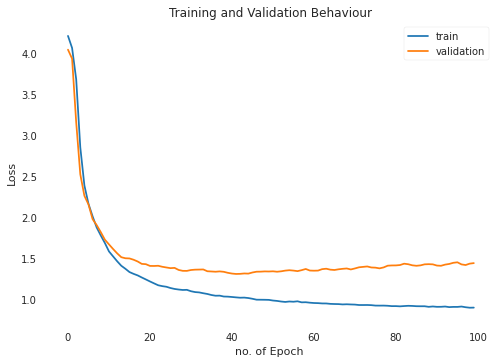

In [83]:
#Create a path to store model details
global DL_path
DL_path = 'Models/lstm_model.h5'    


def create_model(MAX_SESSION_LEN):
    ''' 
    Create an LSTMnetwork
    '''
    # Sequential layer to define tha base of the recurrent model
    clf = Sequential()
    clf.add(LSTM(units=200, input_shape=(MAX_SESSION_LEN, CITY_SET_SIZE), return_sequences=True))#LSTM layer
    clf.add(Dropout(0.1))  # Dropout (avoid Overfitting)
    clf.add(LSTM(units=200)) 
    clf.add(Dense(units=CITY_SET_SIZE, activation='softmax'))
    clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"]) # Multiclass Problem
    clf.summary()
    logging.info('LSTM model has been created')
    return(clf)


def training_pipeline(X_train, X_test, y_train, y_test, MAX_SESSION_LEN):

    model = create_model(MAX_SESSION_LEN)
    ksCallBack = keras.callbacks.TensorBoard(log_dir='./Logs', histogram_freq=0,write_graph=True, write_images=True)
    #Training the Model
    history = model.fit(X_train, y_train, batch_size=128, epochs=100,verbose = 2, validation_split=0.1,shuffle=False, callbacks=[ksCallBack])
    model.save(DL_path)  # save model to single file

    #Evaluating the MOdel
    _,Z = model.evaluate(X_test,y_test, verbose=1)
    logging.info('The Accuracy is : {}'.format(Z))

    # plot history and Comparing the training and Valication Loss
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.title("Training and Validation Behaviour")
    pyplot.xlabel("no. of Epoch ")
    pyplot.ylabel("Loss")
    pyplot.show()
    
    return(Z)

Accuracy_score = training_pipeline(X_train, X_test, y_train, y_test, MAX_SESSION_LEN)



Please note that tensorboard calll back got activated for training process. Following command will let you to dipe dive into the details of training process.


```tensorboard --logdir /Logs  ```

Please also note tahat GridsearchCV can be applied to tune all the hyper paramters:

In [ ]:
```from sklearn.model_selection import GridSearchCV
validator = GridSearchCV(model,
                         param_grid={'dense_layer_sizes': [1,2,3],
                                     # epochs is avail for tuning even when not
                                     # an argument to model building function
                                     'epochs': [50, 100, 200],
                                     'batch_size': [8],
                                     'Optimizer':['RMSprop', 'Adam', 'Adamax', 'sgd']} )
validator.fit(x_train, y_train)
print('The parameters of the best model are: ')
print(validator.best_params_) ```

# Question2 

Given a sequence of searched cities, find the most likely city or cities to be also searched next, within the same session. Your code should include a function that takes a list of 0 to  n cities and returns the most likely next city or cities. Keep in mind that the goal is to call this function each time a user performs a search. It should therefore be fast to execute.


Answer: The following Inference Pipeline takes a list of cities and predict the next city/cities. 

# Inference Pipeline

In Inference pipe, given a list of cities, next sequence of cities will be predicted.

In [84]:
def predict_next_city(input_cities):
    # Loading the Model and Objects ....
    
        label_encoder  = load_encoder(integer_encoder_filename)
        onehot_encoder = load_encoder(onehot_encoder_filename) 
        model= load_model(DL_path)
        integer_encoded = label_encoder.transform(np.array(input_cities))
        padded_integer_encoded = pad_sequences([integer_encoded], maxlen=MAX_SESSION_LEN, padding='post')
        onehot_encoded = [onehot_encoder.transform(padded_integer_encoded.reshape(len(padded_integer_encoded[0]), 1))]
        Infer_Input = np.asarray(np.reshape(onehot_encoded, (len(onehot_encoded), MAX_SESSION_LEN, CITY_SET_SIZE)))

        Inferred = model.predict_classes(Infer_Input,verbose = True)
        prediction_confidence = model.predict(X_test,verbose = True)[0]  # Calculate the prediction Confidence
        #    if(prediction_confidence<0.4):
        #        loggin.warning('Low prediction confidence')

        #logging('prediction_confidence is {}'.format np.max(prediction_confidence))

        Output = label_encoder.inverse_transform(Inferred)
        return(str(Output[0])) 

# Iterative Multistep Seqeuence Prediction 
def predict_next_cities(input_cities,n):
    len0 = len(input_cities)
    while(len(input_cities)<len0+n):
        input_cities.append(predict_next_city(input_cities))
    return(input_cities)

## Example:

In [86]:
input_cities = ['Los Angeles CA', 'Anaheim CA', 'Santa Ana CA'] #, 'Seattle WA']#, 'Portland OR']
user_profile =[1942,'ES','2015-03-01']
print(predict_next_city(input_cities))

1075/1075 [==============================] - 0s 220us/step
New York NY


# Question 3

3. There are few features describing each user: user id, joining date and country. Are these
features useful to predict the most likely city to be searched? How do they compare to
the other features tried in Question 2 (i.e. previous cities searched)? Can the algorithm
implemented in Question 2 be improved by making use of these features?

To answer this question, We came up with a different architecture. As can be seen below, Joining_date and Country will be added to the LSTM model as secondary features and a multi-variate LSTM solution will be implemented, In parallel, ```user_id``` will be used to check the historical data for that specific user. If the sequence-like list is available and the Jacardian similarity is greater than a threshold, a simple ensembling method will be used to merge the results.

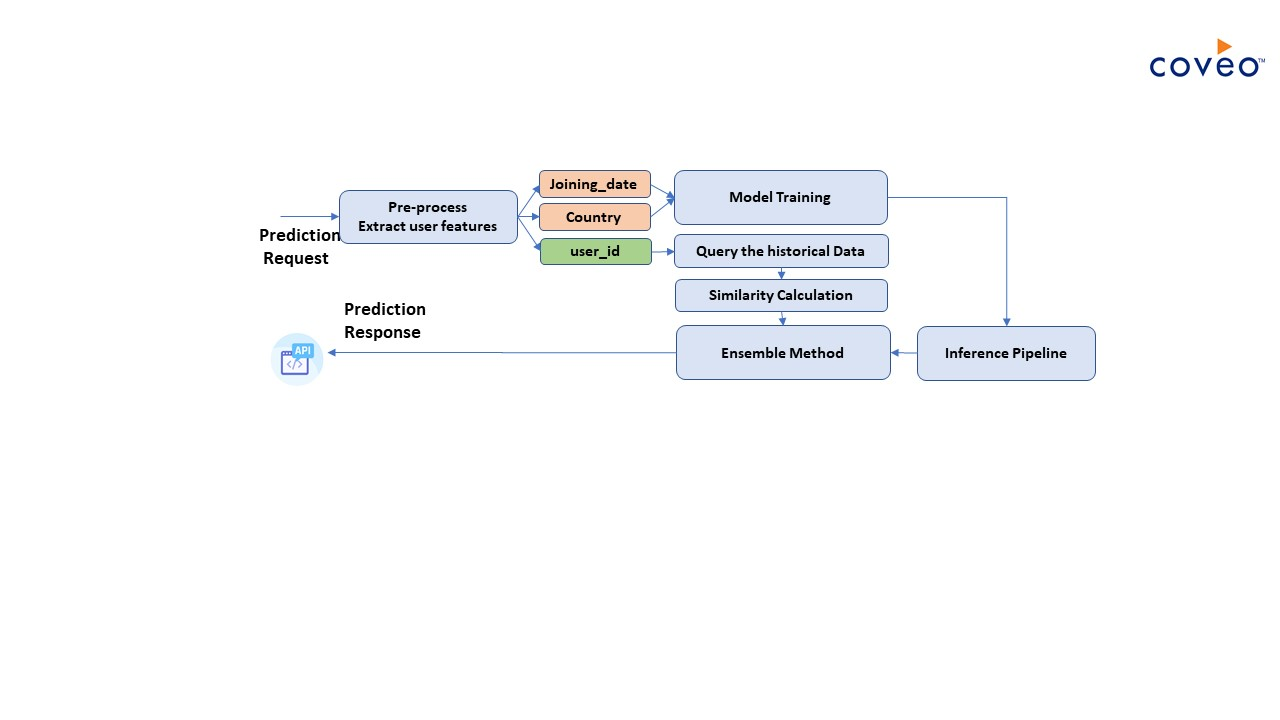

In [87]:
Image(filename='Arch2.jpg')

In [88]:
df_flat['joining_date'] =  pd.to_datetime(df_flat['joining_date'], format='%Y-%m-%d')
df_flat.sort_values(by=['unix_timestamp'], inplace=True, ascending=True)
df_flat['joining_date'].describe()

df_flat['joining_Month'] = df_flat['joining_date'].apply(lambda x: x.month)

As it is described, first joining date is at the end of February while the last one is in April. Thus, only month data is used as a feature for user profiling. Next we convert the country codes to integers.

In [89]:

# Notice that the missing country is encoded as 0
df_flat['country'] = df_flat['country'].astype('category')
country_map = {'': 1, 'ES':2, 'IT':3,  'DE':4, 'FR':5, 'UK':6, 'US':7}
df_flat['country_code'] = df_flat['country'].apply(lambda x: country_map[x])

The only difference compared to previous case, is the dimension. TWo more features are added and consequenctly lenght(dimension) of arrays are two degrees higher.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 12, 200)           232000    
_________________________________________________________________
dropout_14 (Dropout)         (None, 12, 200)           0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_14 (Dense)             (None, 89)                17889     
Total params: 570,689
Trainable params: 570,689
Non-trainable params: 0
_________________________________________________________________
Train on 6732 samples, validate on 748 samples
Epoch 1/100
 - 4s - loss: 3.6608 - accuracy: 0.1347 - val_loss: 3.4372 - val_accuracy: 0.1243
Epoch 2/100
 - 3s - loss: 2.6994 - accuracy: 0.2907 - val_loss: 1.7805 - val_accuracy: 0.4933
Epoch 3/10

Epoch 76/100
 - 3s - loss: 1.1394e-04 - accuracy: 1.0000 - val_loss: 0.0383 - val_accuracy: 0.9947
Epoch 77/100
 - 3s - loss: 1.1196e-04 - accuracy: 1.0000 - val_loss: 0.0387 - val_accuracy: 0.9947
Epoch 78/100
 - 3s - loss: 1.0684e-04 - accuracy: 1.0000 - val_loss: 0.0386 - val_accuracy: 0.9947
Epoch 79/100
 - 3s - loss: 1.0148e-04 - accuracy: 1.0000 - val_loss: 0.0387 - val_accuracy: 0.9947
Epoch 80/100
 - 3s - loss: 9.9300e-05 - accuracy: 1.0000 - val_loss: 0.0389 - val_accuracy: 0.9947
Epoch 81/100
 - 3s - loss: 9.8582e-05 - accuracy: 1.0000 - val_loss: 0.0388 - val_accuracy: 0.9947
Epoch 82/100
 - 3s - loss: 9.3092e-05 - accuracy: 1.0000 - val_loss: 0.0385 - val_accuracy: 0.9947
Epoch 83/100
 - 3s - loss: 8.9732e-05 - accuracy: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9947
Epoch 84/100
 - 3s - loss: 8.7669e-05 - accuracy: 1.0000 - val_loss: 0.0391 - val_accuracy: 0.9947
Epoch 85/100
 - 3s - loss: 8.2331e-05 - accuracy: 1.0000 - val_loss: 0.0389 - val_accuracy: 0.9947
Epoch 86/1

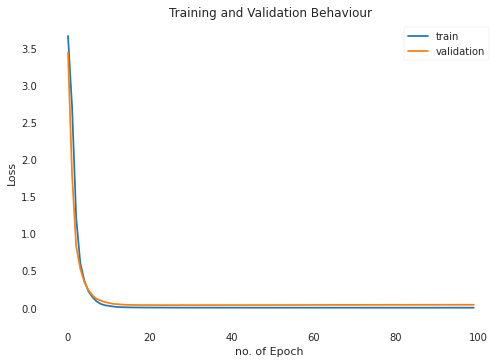

In [90]:
def PreProc_dl_MV(df_flat): 
    
    label_encoder  = load_encoder(integer_encoder_filename)
    onehot_encoder = load_encoder(onehot_encoder_filename)  
    
    
    CityListProc = df_flat['cities'].apply(lambda x:[city.strip() for city in x[0].split(",")]).tolist()
    MonthListProc = df_flat['joining_Month'].tolist()
    CountryListProc = df_flat['country_code'].tolist()
    features_integer_encoded = [label_encoder.transform(y).tolist() for y in CityListProc]

    train_set = []
    label = []
    # Make a list of featurees including previous searched cities, country code and month of joining date
    for i,x in enumerate(features_integer_encoded):

        if(len(x)>1):
            label.append(np.array([x[-1]]))
            x.extend([MonthListProc[i],CountryListProc[i]])
            train_set.append(np.array(x))
    
    features_integer_encoded = train_set
    label_integer_encoded = label
    padded_features_integer_encoded = pad_sequences(features_integer_encoded, maxlen=MAX_SESSION_LEN+2)
    features_onehot_encoded = [onehot_encoder.transform(z.reshape(len(z), 1)) for z in padded_features_integer_encoded]
    label_onehot_encoded = [onehot_encoder.transform(z.reshape(len(z), 1)) for z in label_integer_encoded]
    
    X_train, X_test, y_train, y_test = train_test_split(features_onehot_encoded, label_onehot_encoded, test_size=0.2, random_state=42)

    X_train = np.asarray(X_train)
    y_train =np.asarray(y_train)

    X_test = np.asarray(X_test)
    y_test =np.asarray(y_test)

    # Reshape the data to be able to put it into Keras' LSTM module
    X_train = np.asarray(np.reshape(X_train, (len(X_train), MAX_SESSION_LEN+2, CITY_SET_SIZE)))
    # Reshape labels to work with Keras's sparse_categorical_crossentropy 
    y_train = np.asarray(np.reshape(y_train, (y_train.shape[0], CITY_SET_SIZE)))

    # Reshape the data to be able to put it into Keras' LSTM module
    X_test = np.asarray(np.reshape(X_test, (len(X_test), MAX_SESSION_LEN+2, CITY_SET_SIZE)))
    # Reshape labels to work with Keras's sparse_categorical_crossentropy 
    y_test = np.asarray(np.reshape(y_test, (y_test.shape[0], CITY_SET_SIZE)))


    return(X_train, X_test, y_train, y_test)
        
X_train, X_test, y_train, y_test = PreProc_dl_MV(df_flat) 
Accuracy_score = training_pipeline(X_train, X_test, y_train, y_test, MAX_SESSION_LEN+2)

Accuracy is suspiciously high!!!

In [68]:
Accuracy_score

0.9989310503005981

In [99]:
import datetime
def bin_seq(x):
    return([city.strip() for city in x.split(",")])

tempdf = pd.DataFrame({'agg_cities' : df_flat.groupby('user_id')['cities'].apply(lambda x: "%s" % ', '.join(x.sum())) }).reset_index()
tempdf['agg_cities']= tempdf['agg_cities'].apply(bin_seq)  # Aggregate Cities searched by a user in a new temporary data frame

def queryX(user_id,tempdf):
    User_prof = tempdf[tempdf['user_id']==user_id]['agg_cities'].tolist()[0] # Filter the sequence for the User ID
    List = [User_prof[i:i+len(input_cities)] for i in range(0,len(User_prof)-len(input_cities))]
    Similarity_score = [len(list(set(input_cities) & set(x)))/len(input_cities) for x  in List] #Calculating Jacardian Distance
    if (max(Similarity_score)>0.8):
        output= List[np.argmax(Similarity_score)+1][-1]
    else:
        output = 'NULL'
    return(output)

def predict_next_city_mv(input_cities,user_profile):
    
    model= load_model(DL_path)
    label_encoder  = load_encoder(integer_encoder_filename)
    onehot_encoder = load_encoder(onehot_encoder_filename) 
    # Loading the Model and Objects ....
    integer_encoded = label_encoder.transform(np.array(input_cities)).tolist()
    # Add country code and joinng month to the label encoded vector
    integer_encoded.extend([country_map[user_profile[1]],datetime.datetime.strptime(user_profile[2], '%Y-%m-%d').month])  
    integer_encoded =np.array(integer_encoded)
    
    padded_integer_encoded = pad_sequences([integer_encoded], maxlen=MAX_SESSION_LEN+2, padding='post')
    onehot_encoded = [onehot_encoder.transform(padded_integer_encoded.reshape(len(padded_integer_encoded[0]), 1))]
    Infer_Input = np.asarray(np.reshape(onehot_encoded, (len(onehot_encoded), MAX_SESSION_LEN+2, CITY_SET_SIZE)))
    
    Inferred = model.predict_classes(Infer_Input,verbose = True)
    prediction_confidence = model.predict(X_test,verbose = True)[0] 
    
    Output = label_encoder.inverse_transform(Inferred)
    
    # Ensembling the results of different methods: If the query outout result is accurate enough then we forward it otherwise we ignore it
    user_id =user_profile[0]
    Output_Q = queryX(user_id,tempdf) #
    if Output_Q != 'NULL':
        Output_Fin = [Output_Q ,str(Output[0])]
    else:
        Output_Fin=str(Output[0])
    
    return(np.max(prediction_confidence), Output_Fin) 

# Iterative method for multi-step prediction 
def predict_next_cities_mv(input_cities,user_profile,n):
    len0 = len(input_cities)
    while(len(input_cities)<len0+n):
        input_cities.append(predict_next_city(input_cities,user_profile,n))
    return(input_cities)


predict_next_city_mv(input_cities,user_profile)


1871/1871 [==============================] - 0s 249us/step


(0.999959, ['Long Beach CA', 'Anaheim CA'])

#  Question 4             
                 

4. How did you measure the performance of the prediction algorithms from questions 2 and 3 ? What is your confidence that the measured score is accurate?


The proposed performance metric is Accuracy and it can be categorized as the function of the minimum sequence length of the sequence model it can predict. 

Accuracy as the main performance metric is calculated at ```training pipeline``` via test datasets and is the output of the training pipeline function. 

For each prediction the level of confidence is calculated at ```predict_next_city``` function.

   

Please note that all the path,addresses and global fixed variables are stored at config.json. Moreover, all the functions and methods are implemented in seqpred.py.